In [64]:
from utils.utils import train_model, evaluate_model_with_cm, TiffDataset
from models.video_classifier import VideoClassifier, TransformerModel
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.init as init

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
val_filter = lambda x: x >= 1 and (x % 50) in {1, 6, 13, 18, 25, 30, 32, 37, 44, 49}

In [15]:
bands = 4
num_epochs = 100
patch_sizes = [1, 3, 5, 7, 9, 11]
result_df_dicts = {"patch_size": [],
                   "data_type" : [],
                   "df" : []}
os.makedirs("./checkpoints/patch_size_test", exist_ok=True) #checkpoints 저장할 dir
large_tif_dir = '../../data/source_data/naive' #원천데이터 주소

class ReshapeTransform:
    """(12*bands, 3, 3) → (12, bands, 3, 3) 변환"""
    def __init__(self, bands, patch_size):
        self.bands = bands
        self.patch_size = patch_size
    def __call__(self, x):
        return x.view(12, self.bands, self.patch_size, self.patch_size).permute(1, 0, 2, 3)

def get_transform(bands, patch_size, scale_channels_func=None):
    transform_list = [
        transforms.ToTensor(),  # (H, W, C) → (C, H, W)
        transforms.Lambda(lambda x: x.float()),  # uint16 → float 변환
        ReshapeTransform(bands, patch_size)  # (12*bands, 3, 3) → (bands, 12, 3, 3)
    ]

    if scale_channels_func:
        transform_list.append(transforms.Lambda(scale_channels_func))  # 채널별 값 조정 추가

    return transforms.Compose(transform_list)

#scaling 함수 - 채널별로 범위의 차이가 크기때문에 어느정도 맞추어주기 위해서 수행
def scale_channels(x):
    """특정 채널값 조정"""
    x[0:3] *= 5  # B,G,R 채널 * 5
    if 4 < x.shape[0]:
        x[4] *= 0.5  # NDVI 채널 * 0.5
    return x


patch_size = 1

transform = get_transform(bands, patch_size, scale_channels)

train_dataset = TiffDataset(
            large_tif_dir = large_tif_dir,
            file_list = ["jiri_1.tif", "jiri_2.tif", "sobaek.tif"], #전체 지역을 모두 사용한다.
            label_file = "../../data/label_data/species/label_mapping_sampled.csv",
            box_filter_fn = lambda box_number: not val_filter(box_number),
            patch_size = patch_size,
            transform=transform
        )

val_dataset = TiffDataset(
            large_tif_dir = large_tif_dir,
            file_list = ["jiri_1.tif", "jiri_2.tif", "sobaek.tif"], #전체 지역을 모두 사용한다.
            label_file ="../../data/label_data/species/label_mapping_sampled.csv",
            box_filter_fn = val_filter,
            patch_size = patch_size,
            transform=transform
        )

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

model = TransformerModel(patch_size=patch_size).to(device)
model.load_state_dict(torch.load(f"./checkpoints/patch_size_test/transformer_{bands}_{patch_size}_{num_epochs}.pth"))

<All keys matched successfully>

In [30]:
# import torch
# import torch.nn.functional as F
# import numpy as np
# from tqdm import tqdm

# def add_noise(data, noise_level=1.0):
#     """
#     각 픽셀 값에 비례하여 랜덤 노이즈를 추가하는 함수.

#     noise_level = 1.0이면, 
#     - 픽셀값 X에 대해 X + (-X ~ X) (즉, 0~2X 범위)로 변환됨.
#     - noise_level = 2.0이면, X + (-2X ~ 2X) (즉, -X ~ 3X 범위)로 변환됨.

#     Args:
#         data (torch.Tensor): (Bands, Time, Height, Width) 형태의 입력 데이터
#         noise_level (float): 노이즈 강도 계수 (기본값 1.0)

#     Returns:
#         torch.Tensor: 노이즈가 추가된 데이터
#     """
#     noise = (torch.rand_like(data) * 2 - 1) * (data * noise_level)  # [-X, X] 범위의 노이즈 생성
#     return data + noise  # 원본 데이터에 노이즈를 추가하여 반환

# def evaluate_perturbation(model, dataloader, num_classes=6, noise_level=0.1, num_repeats=1):
#     """
#     모델의 교란(노이즈) 영향 평가 및 반복 실험 후 평균 히트맵 생성

#     Args:
#         model (torch.nn.Module): 학습된 모델
#         dataloader (torch.utils.data.DataLoader): 입력 데이터로더
#         num_classes (int): 예측할 클래스 개수 (기본값 6)
#         noise_level (float): 노이즈 강도 계수 (기본값 0.1)
#         num_repeats (int): 반복 실험 횟수 (기본값 5)

#     Returns:
#         tuple:
#             - (num_classes, Band, Time) 크기의 평균화된 히트맵 (numpy 배열)
#             - (num_classes, Band, Time) 크기의 count_map (numpy 배열)
#     """
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # GPU 사용 가능하면 GPU로 설정
#     model.to(device)  # 모델을 GPU 또는 CPU로 이동
#     model.eval()  # 모델을 평가 모드로 설정 (dropout, batch norm 등의 영향 제거)

#     # 데이터셋에서 사용하는 밴드(band) 및 시간(time) 차원 크기 설정
#     band, time = 4, 12  # (예시: 4개의 스펙트럼 밴드, 12개의 시계열 데이터)

#     # 여러 번 실험 후 평균을 내기 위한 히트맵 초기화
#     total_heatmap = torch.zeros((num_classes, band, time), device=device)  # 각 클래스별 중요도 저장
#     total_count_map = torch.zeros((num_classes, band, time), device=device)  # 픽셀 개수 저장 (평균 계산 시 사용)

#     with torch.no_grad():  # 그래디언트 계산 비활성화 (메모리 사용량 절감)
#         for repeat in range(num_repeats):  # num_repeats 번 실험 반복
#             heatmap = torch.zeros((num_classes, band, time), device=device)  # 현재 반복 실험의 히트맵
#             count_map = torch.zeros((num_classes, band, time), device=device)  # 현재 반복 실험의 count_map

#             for data, labels in tqdm(dataloader, desc=f"Experiment {repeat+1}/{num_repeats}"):
#                 data, labels = data.to(device), labels.to(device)  # 데이터를 GPU 또는 CPU로 이동
#                 B, Band, Time, H, W = data.shape  # 데이터 차원 추출

#                 # 1. 원본 데이터를 모델에 통과시켜 예측값(logit) 저장
#                 original_logits = model(data)  # (B, num_classes, H, W) 크기의 logit 출력
#                 original_preds = original_logits.argmax(dim=1)  # (B, H, W), 가장 확률 높은 클래스 선택

#                 # 2. True Positive(TP) 마스크 생성 (정확하게 예측한 픽셀만 고려)
#                 tp_mask = (original_preds == labels)  # (B, H, W) 크기의 True/False 마스크

#                 # 3. 밴드(b)와 시간(t) 차원을 순회하며 데이터 교란 수행
#                 for b in range(band):  # 각 밴드에 대해 반복
#                     for t in range(time):  # 각 시간 스텝에 대해 반복
#                         perturbed_data = data.clone()  # 데이터 복사 (원본 유지)
#                         perturbed_data[:, b, t] = add_noise(perturbed_data[:, b, t], noise_level)  # 특정 밴드-시간 축에 노이즈 추가

#                         # 4. 교란된 데이터를 모델에 통과시켜 새로운 logit 얻기
#                         perturbed_logits = model(perturbed_data)  # (B, num_classes, H, W) 크기의 예측값

#                         # 5. 원본 logit과 교란된 logit 간 MSE(평균제곱오차) 계산
#                         mse_loss = F.mse_loss(original_logits, perturbed_logits, reduction='none')  # (B, num_classes, H, W)
#                         mse_loss = mse_loss.mean(dim=1)  # 클래스 차원 평균 → (B, H, W)

#                         # 6. TP였던 픽셀에 대해 MSE 변화량을 히트맵에 누적
#                         for c in range(num_classes):  # 각 클래스별 반복
#                             class_mask = (original_preds == c)  # 원본 예측이 해당 클래스였던 위치
#                             valid_mask = tp_mask & class_mask  # TP 중에서 해당 클래스인 위치

#                             heatmap[c, b, t] += mse_loss[valid_mask].sum()  # MSE 변화량 누적
#                             count_map[c, b, t] += valid_mask.sum()  # TP 개수 누적

#             # 현재 반복 실험의 결과를 전체 결과에 누적
#             total_heatmap += heatmap
#             total_count_map += count_map

#     # 7. num_repeats 만큼 평균을 내기
#     total_heatmap /= num_repeats
#     total_count_map /= num_repeats

#     # 8. 히트맵 정규화 (각 클래스별로 중요도를 1로 맞춤)
#     for c in range(num_classes):
#         if total_heatmap[c].sum() > 0:  # 0으로 나누는 것 방지
#             total_heatmap[c] /= total_heatmap[c].sum()  # 히트맵을 전체 합이 1이 되도록 정규화
#             total_heatmap[c] *= (band * time)  # 48로 맞춤 (band=4, time=12)

#     return total_heatmap.cpu().numpy(), total_count_map.cpu().numpy()


In [54]:
import torch
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm

def add_noise(data, noise_level=1.0):
    """
    데이터에 랜덤 노이즈를 추가하는 함수.

    Args:
        data (torch.Tensor): 입력 데이터 (Bands, Time, Height, Width)
        noise_level (float): 노이즈 강도 계수

    Returns:
        torch.Tensor: 노이즈가 추가된 데이터
    """
    noise = (torch.rand_like(data) * 2 - 1) * (data * noise_level)
    return data + noise

def evaluate_perturbation(model, dataloader, num_classes=6, noise_level=0.1, num_repeats=1):
    """
    모델의 교란(노이즈) 영향 평가 및 중요도 히트맵 생성 (기존 + 새로운 방법 포함)

    Args:
        model (torch.nn.Module): 학습된 모델
        dataloader (torch.utils.data.DataLoader): 데이터 로더
        num_classes (int): 클래스 개수
        noise_level (float): 노이즈 강도
        num_repeats (int): 반복 실험 횟수

    Returns:
        tuple:
            - 히트맵 (num_classes, band, time)
            - count_map (num_classes, band, time)
            - band별 중요도 (num_classes, band)
            - time별 중요도 (num_classes, time)
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    band, time = 4, 12  # 데이터의 밴드 수와 시간 스텝 수

    # 결과 저장용 변수
    total_heatmap = torch.zeros((num_classes, band, time), device=device)
    total_count_map = torch.zeros((num_classes, band, time), device=device)
    total_band_importance = torch.zeros((num_classes, band), device=device)
    total_time_importance = torch.zeros((num_classes, time), device=device)

    with torch.no_grad():
        for repeat in range(num_repeats):
            heatmap = torch.zeros((num_classes, band, time), device=device)
            band_importance = torch.zeros((num_classes, band), device=device)
            time_importance = torch.zeros((num_classes, time), device=device)

            for data, labels in tqdm(dataloader, desc=f"Experiment {repeat+1}/{num_repeats}"):
                data, labels = data.to(device), labels.to(device)
                B, Band, Time, H, W = data.shape

                # 1. 원본 예측값 저장
                original_logits = model(data)
                original_preds = original_logits.argmax(dim=1)

                # 2. True Positive(TP) 마스크 생성
                tp_mask = (original_preds == labels)

                # 3. 기존 방법: band, time의 특정 값만 교란
                for b in range(band):
                    for t in range(time):
                        perturbed_data = data.clone()
                        perturbed_data[:, b, t] = add_noise(perturbed_data[:, b, t], noise_level)

                        perturbed_logits = model(perturbed_data)
                        mse_loss = F.mse_loss(original_logits, perturbed_logits, reduction='none').mean(dim=1)

                        for c in range(num_classes):
                            class_mask = (original_preds == c)
                            valid_mask = tp_mask & class_mask
                            heatmap[c, b, t] += mse_loss[valid_mask].sum()

                # 4. 새로운 방법 1️⃣: band 전체를 교란하여 중요도 측정
                for b in range(band):
                    perturbed_data = data.clone()
                    perturbed_data[:, b] = add_noise(perturbed_data[:, b], noise_level)

                    perturbed_logits = model(perturbed_data)
                    mse_loss = F.mse_loss(original_logits, perturbed_logits, reduction='none').mean(dim=1)

                    for c in range(num_classes):
                        class_mask = (original_preds == c)
                        valid_mask = tp_mask & class_mask
                        band_importance[c, b] += mse_loss[valid_mask].sum()

                # 5. 새로운 방법 2️⃣: time 전체를 교란하여 중요도 측정
                for t in range(time):
                    perturbed_data = data.clone()
                    perturbed_data[:, :, t] = add_noise(perturbed_data[:, :, t], noise_level)

                    perturbed_logits = model(perturbed_data)
                    mse_loss = F.mse_loss(original_logits, perturbed_logits, reduction='none').mean(dim=1)

                    for c in range(num_classes):
                        class_mask = (original_preds == c)
                        valid_mask = tp_mask & class_mask
                        time_importance[c, t] += mse_loss[valid_mask].sum()

            # 반복 실험 결과 누적
            total_heatmap += heatmap
            total_band_importance += band_importance
            total_time_importance += time_importance

    # 평균 내기
    total_heatmap /= num_repeats
    total_band_importance /= num_repeats
    total_time_importance /= num_repeats

    # 히트맵 정규화 (기존 방식)
    for c in range(num_classes):
        if total_heatmap[c].sum() > 0:
            total_heatmap[c] /= total_heatmap[c].sum()
            total_heatmap[c] *= (band * time)

    # 새로운 방식 정규화 (band, time 각각 정규화)
    for c in range(num_classes):
        if total_band_importance[c].sum() > 0:
            total_band_importance[c] /= total_band_importance[c].sum()
            total_band_importance[c] *= band

        if total_time_importance[c].sum() > 0:
            total_time_importance[c] /= total_time_importance[c].sum()
            total_time_importance[c] *= time

    return (
        total_heatmap.cpu().numpy(),  # (num_classes, band, time)
        total_band_importance.cpu().numpy(),  # (num_classes, band)
        total_time_importance.cpu().numpy()  # (num_classes, time)
    )

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 날짜 라벨 설정
dates = ['0201', '0301', '0401', '0415', '0501', '0515', '0601', '0701', '0901', '1001', '1015', '1101']

# 클래스 이름 매핑
target_name_mapping = {
    0: "NF",  # Non-Forest, 비산림
    1: "PD",  # Pinus densiflora, 소나무
    2: "PK",  # Pinus koraiensis, 잣나무
    3: "LK",  # Larix kaempferi, 낙엽송
    4: "QM",  # Quercus mongolica, 신갈나무
    5: "QV"   # Quercus variabilis, 굴참나무
}

def plot_importance_maps(importance_maps, band_importance, time_importance):
    """
    중요도 맵을 시각화하는 함수

    Args:
        importance_maps (np.array): (num_classes, num_bands, num_times) 형태의 중요도 맵
        band_importance (np.array): (num_classes, num_bands) 밴드별 중요도 (모든 값 교란)
        time_importance (np.array): (num_classes, num_times) 시기별 중요도 (모든 값 교란)
    """
    num_classes, num_bands, num_times = importance_maps.shape

    # 클래스별로 3개의 그래프 (히트맵, 교란된 밴드 중요도, 교란된 시기 중요도)
    fig, axes = plt.subplots(num_classes, 3, figsize=(18, 4 * num_classes))

    for cls in range(num_classes):
        class_name = target_name_mapping[cls]  # 클래스 이름 가져오기

        # 1️⃣ 시기별 & 밴드별 중요도 히트맵
        ax = axes[cls, 0]
        sns.heatmap(importance_maps[cls], cmap="coolwarm", annot=True, fmt=".2f", ax=ax)
        ax.set_title(f"{class_name}: Temporal & Band Importance")
        ax.set_xlabel("Time (Dates)")
        ax.set_ylabel("Bands (B, G, R, NIR)")
        ax.set_xticks(np.arange(num_times))
        ax.set_xticklabels(dates, rotation=45)  # 날짜 라벨 적용

        # 2️⃣ 새로운 방식: 교란된 밴드별 중요도 바 그래프
        ax = axes[cls, 1]
        ax.bar(["B", "G", "R", "NIR"], band_importance[cls], color=["blue", "green", "red", "purple"])
        ax.set_title(f"{class_name}: Band Importance")
        ax.set_ylabel("Importance Score")

        # 3️⃣ 새로운 방식: 교란된 시기별 중요도 바 그래프
        ax = axes[cls, 2]
        ax.bar(dates, time_importance[cls], color="darkorange")
        ax.set_title(f"{class_name}: Temporal Importance")
        ax.set_xlabel("Time (Dates)")
        ax.set_ylabel("Importance Score")
        ax.set_xticks(np.arange(num_times))
        ax.set_xticklabels(dates, rotation=45)  # 날짜 라벨 적용

    plt.tight_layout()
    plt.show()


Transformer-patch_size = 1

Experiment 3/3: 100%|███████████████████████████████████████████████████████| 3796/3796 [11:52<00:00,  5.33it/s]


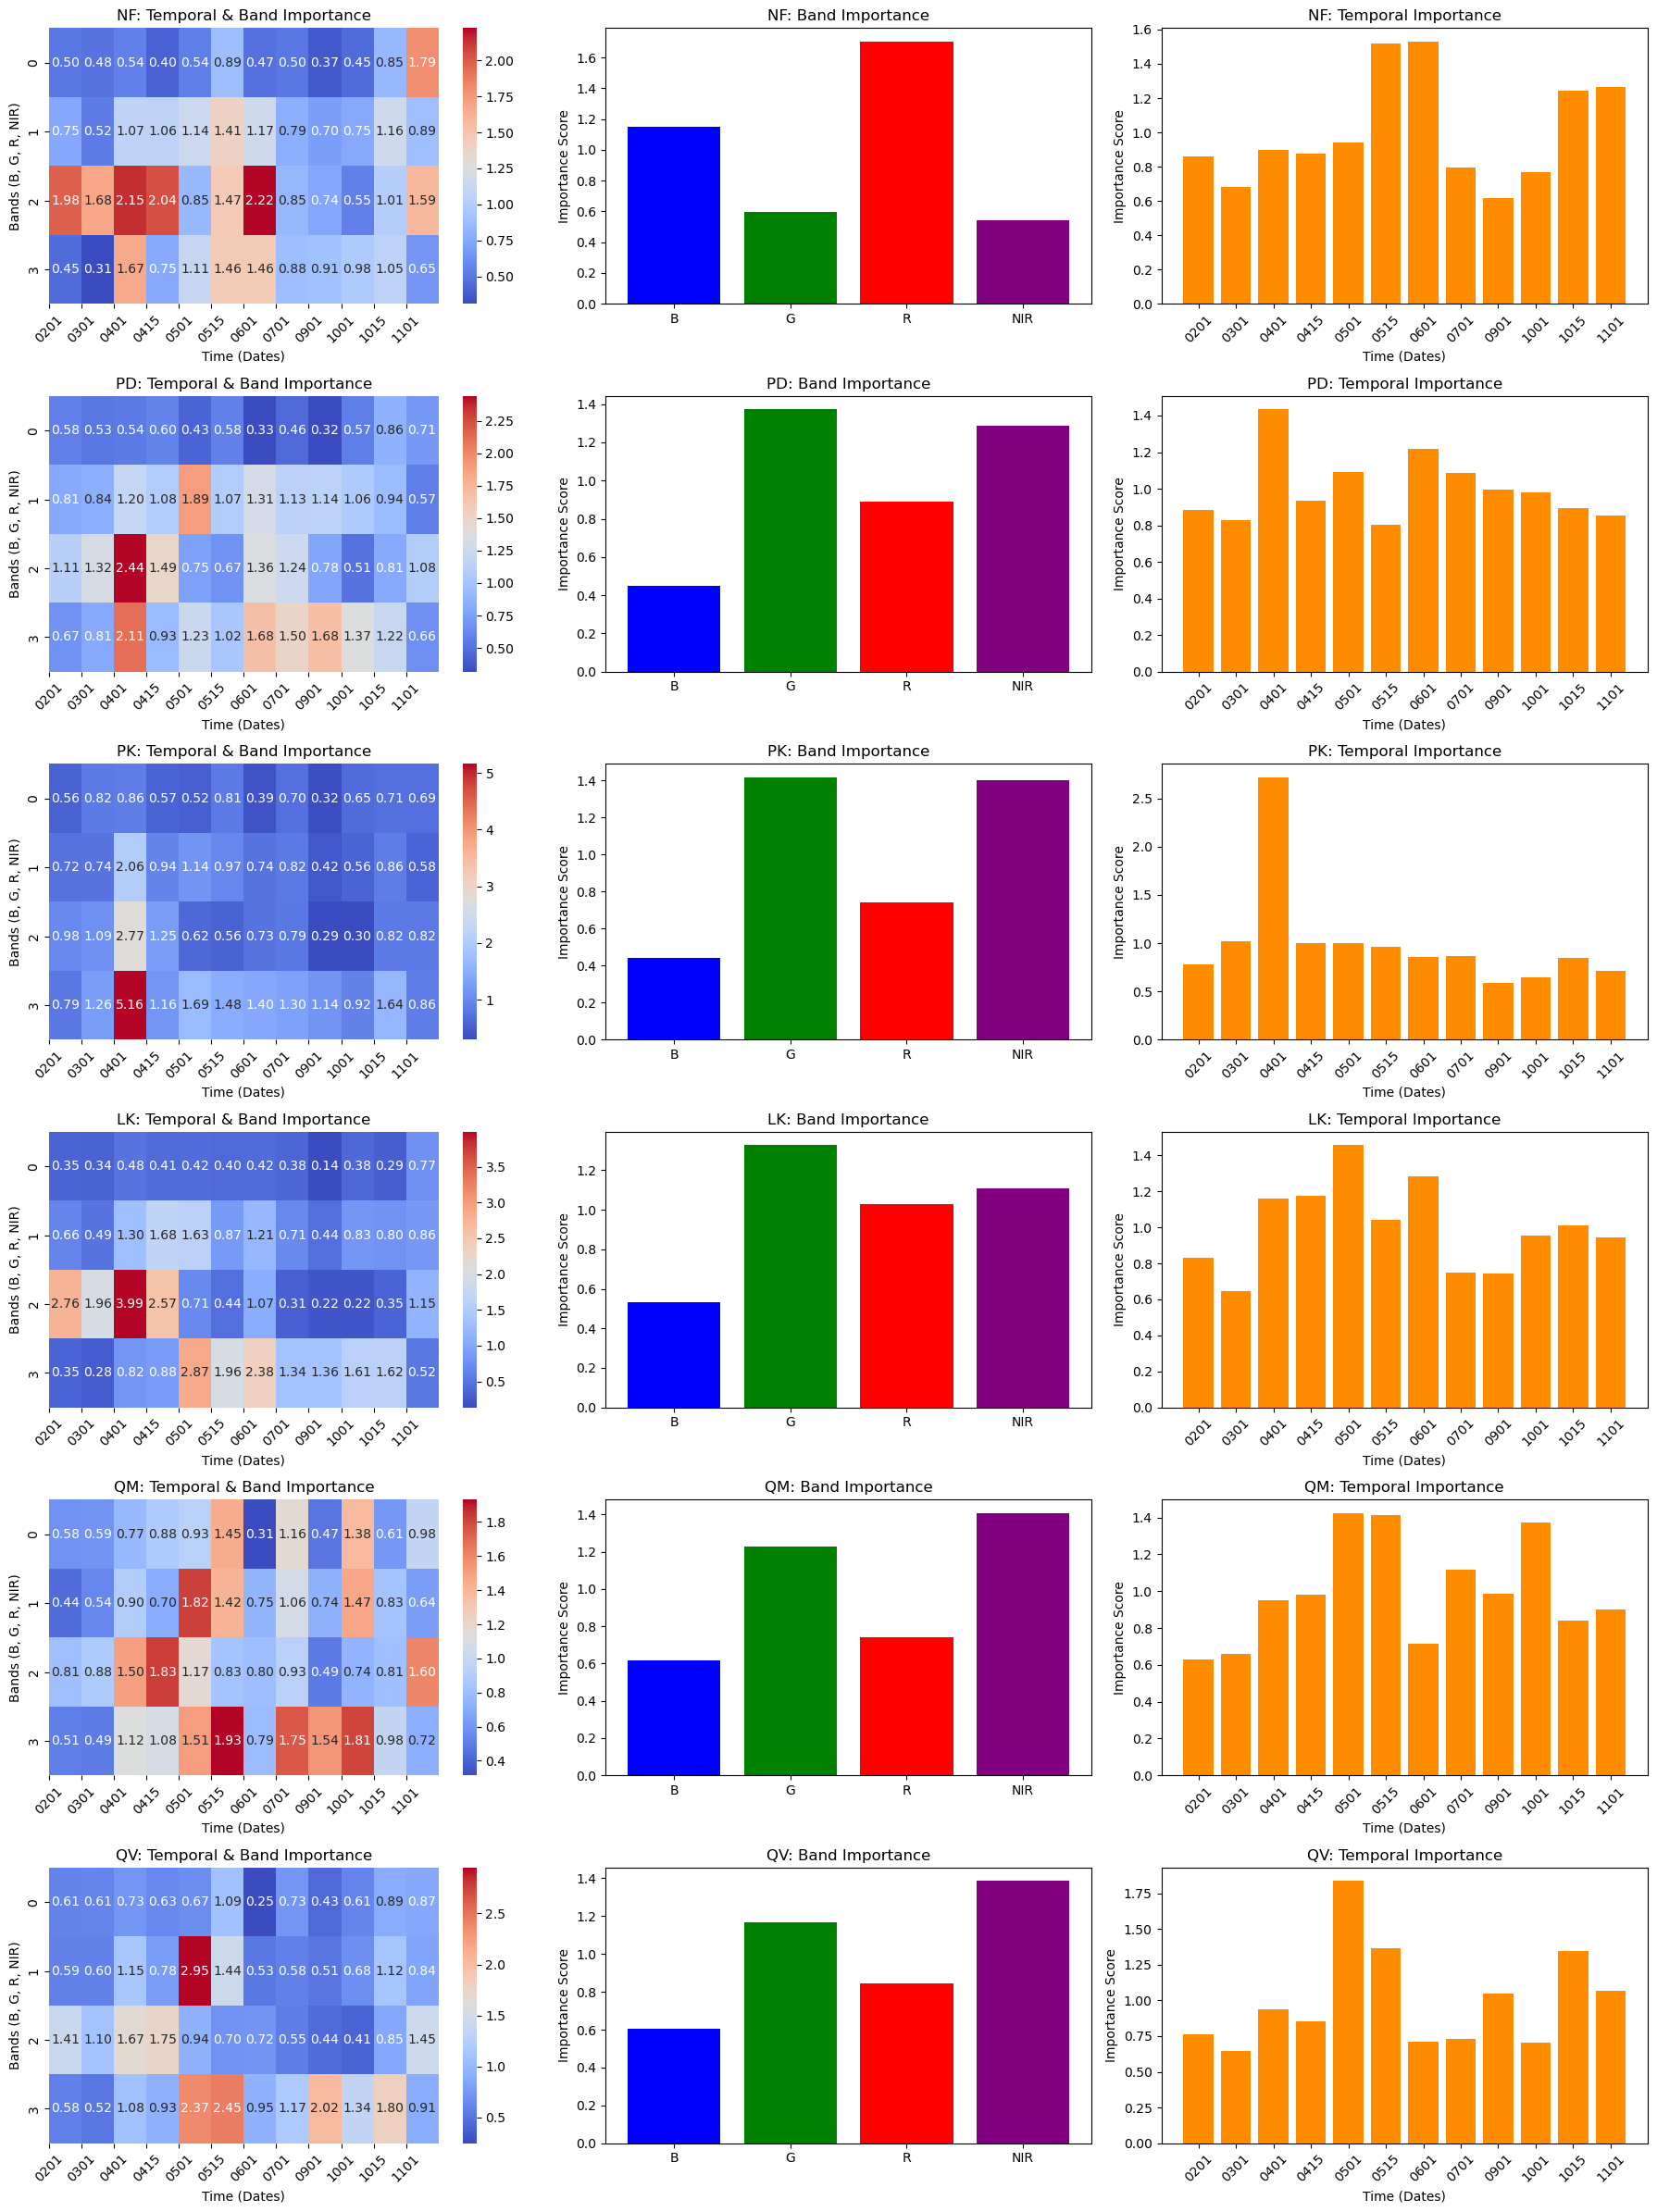

In [56]:
importance_maps, band_importance, time_importance  = evaluate_perturbation(model, train_loader, num_classes=6, noise_level=1.0, num_repeats=3)
plot_importance_maps(importance_maps, band_importance, time_importance)

Transformer-patch_size = 9

In [59]:
patch_size = 9

transform = get_transform(bands, patch_size, scale_channels)

train_dataset = TiffDataset(
            large_tif_dir = large_tif_dir,
            file_list = ["jiri_1.tif", "jiri_2.tif", "sobaek.tif"], #전체 지역을 모두 사용한다.
            label_file = "../../data/label_data/species/label_mapping_sampled.csv",
            box_filter_fn = lambda box_number: not val_filter(box_number),
            patch_size = patch_size,
            transform=transform
        )

val_dataset = TiffDataset(
            large_tif_dir = large_tif_dir,
            file_list = ["jiri_1.tif", "jiri_2.tif", "sobaek.tif"], #전체 지역을 모두 사용한다.
            label_file ="../../data/label_data/species/label_mapping_sampled.csv",
            box_filter_fn = val_filter,
            patch_size = patch_size,
            transform=transform
        )

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

model = TransformerModel(patch_size=patch_size).to(device)
model.load_state_dict(torch.load(f"./checkpoints/transformer/transformer_{bands}_{patch_size}_{num_epochs}_0.pth"))

<All keys matched successfully>

Experiment 3/3: 100%|███████████████████████████████████████████████████████| 3773/3773 [12:06<00:00,  5.20it/s]


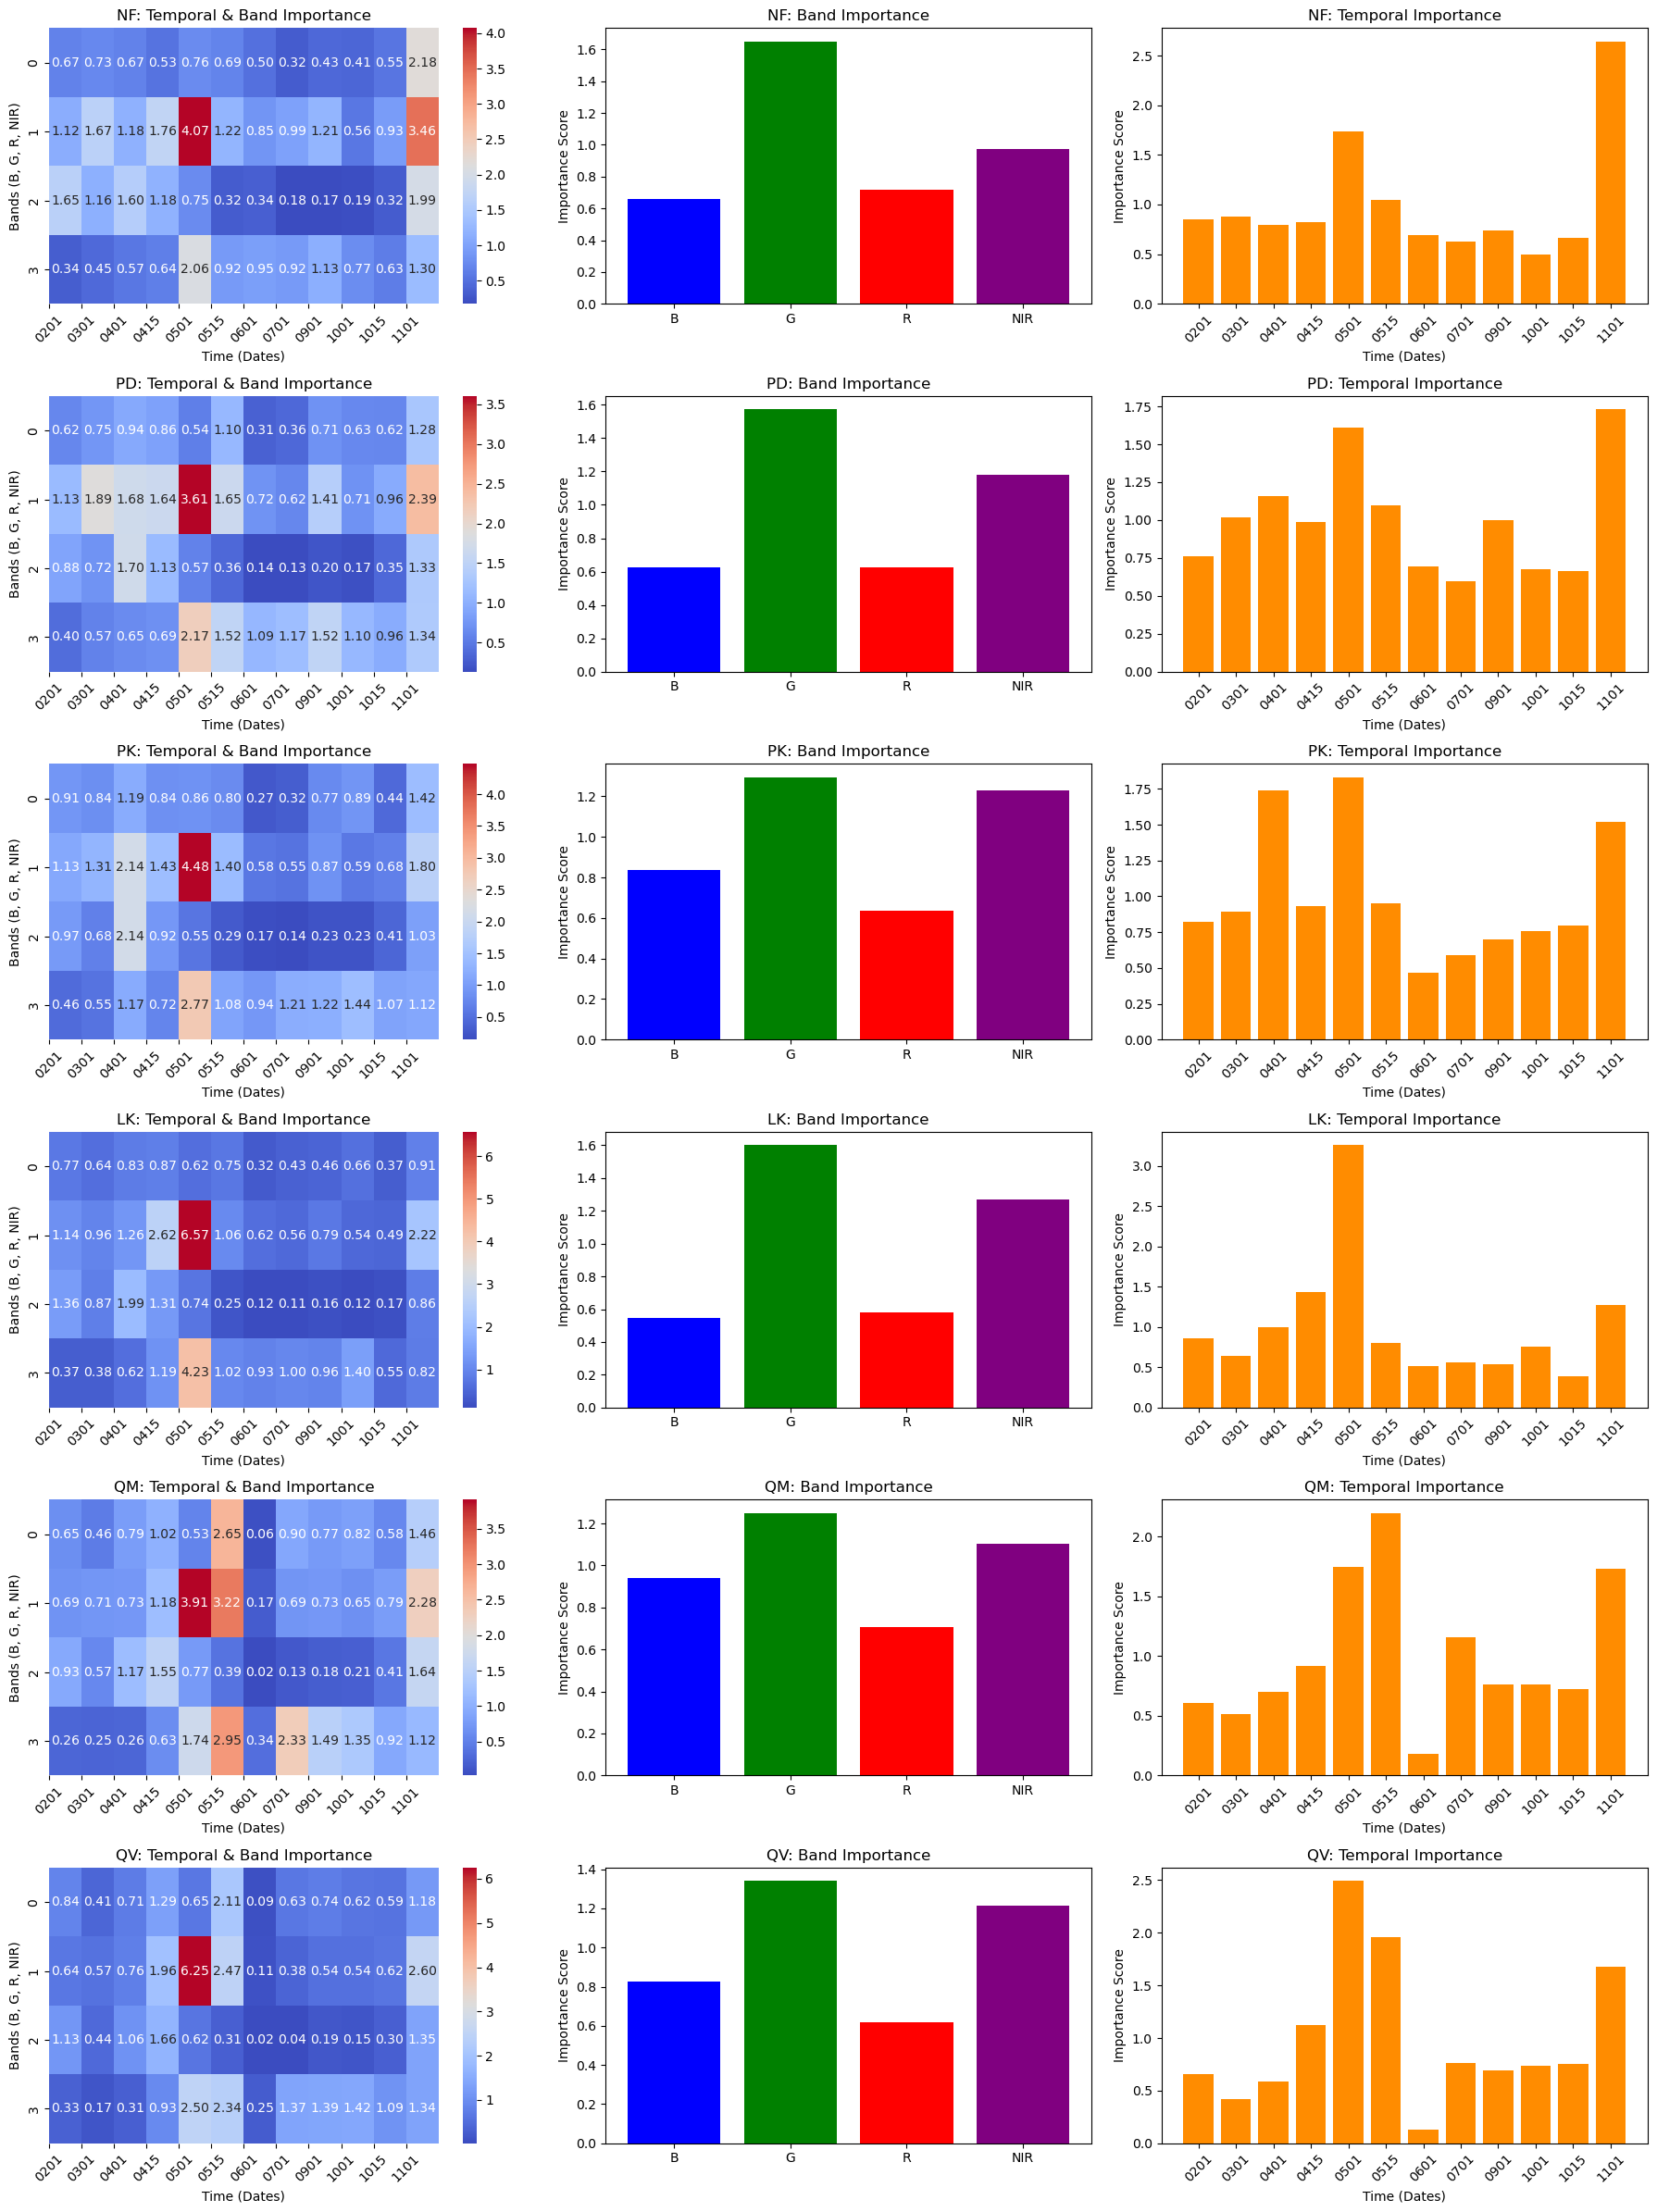

In [60]:
importance_maps, band_importance, time_importance  = evaluate_perturbation(model, train_loader, num_classes=6, noise_level=1.0, num_repeats=3)
plot_importance_maps(importance_maps, band_importance, time_importance)

cnn - patch_size =9

In [66]:
# 모델 설정
stage_repeats = [2, 2, 3, 2]  
stage_channels = [16,24,35,48]
num_classes = 6  # 분류할 클래스 개수

# 모델 생성
model = VideoClassifier(bands, stage_repeats, stage_channels, num_classes=num_classes).to(device)
model.load_state_dict(torch.load(f"./checkpoints/cnn/cnn_{bands}_{patch_size}_{num_epochs}_0.pth"))

<All keys matched successfully>

Experiment 1/1: 100%|███████████████████████████████████████████████████████| 3773/3773 [55:10<00:00,  1.14it/s]


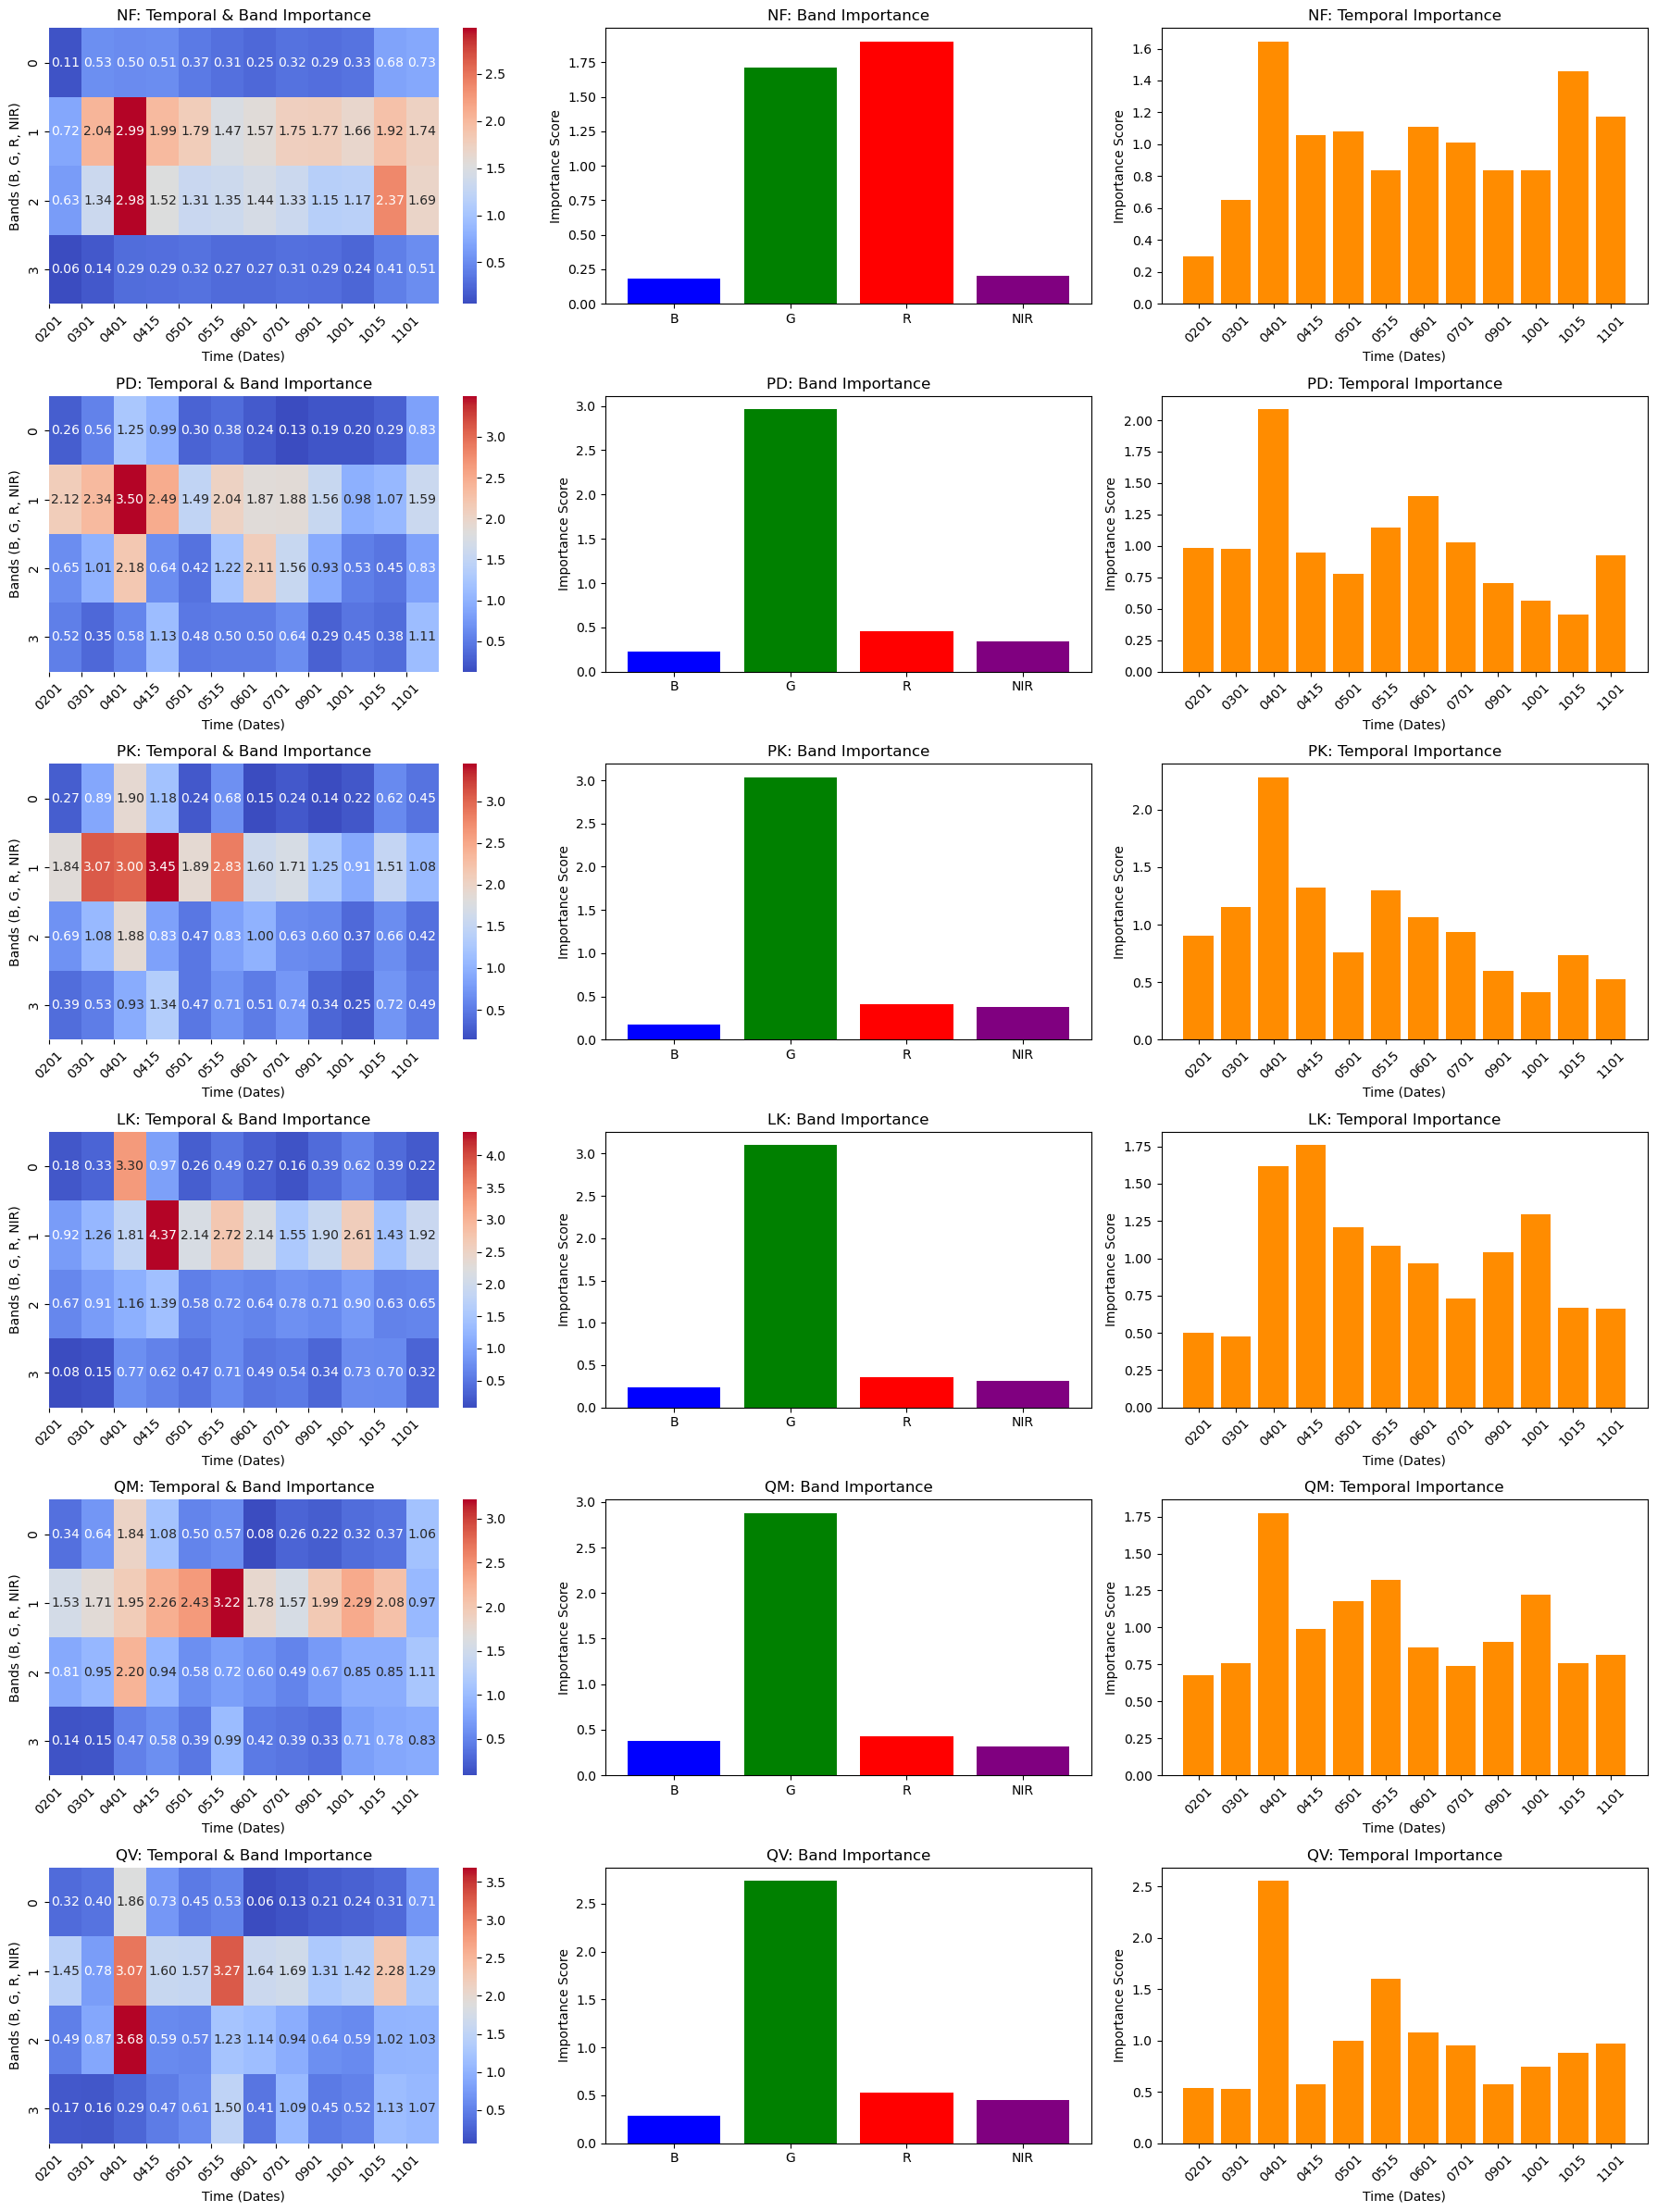

In [68]:
importance_maps, band_importance, time_importance  = evaluate_perturbation(model, train_loader, num_classes=6, noise_level=1.0, num_repeats=1)
plot_importance_maps(importance_maps, band_importance, time_importance)